In [1]:
# Include so results on different machines are (should be) the same.
from numpy.random import seed
seed(1)

from tensorflow import set_random_seed
set_random_seed(2)

In [2]:
!jupyter nbconvert --to script Keras_BagnallCharacter_RNN.ipynb

[NbConvertApp] Converting notebook Keras_BagnallCharacter_RNN.ipynb to script
[NbConvertApp] Writing 12963 bytes to Keras_BagnallCharacter_RNN.py


In [3]:
import glob, os, json, re, unicodedata
from bs4 import BeautifulSoup

load_verbose = 0
loaded_labels = []
loaded_text = []
presidents = [
    "Barack Obama",
    "Donald J. Trump",
    "Dwight D. Eisenhower",
    "Franklin D. Roosevelt",
    "George Bush",
    "George W. Bush",
#     "Gerald R. Ford",
    "Harry S. Truman",
#     "Herbert Hoover",
    "Jimmy Carter",
    "John F. Kennedy",
    "Lyndon B. Johnson",
    "Richard Nixon",
    "Ronald Reagan",
    "William J. Clinton"
]

labels = {}
for idx, name in enumerate(presidents):
    labels[name] = idx

# load raw text files straight in, no parsing
file_to_label = {
    "Obama": "Barack Obama",
    "Trump": "Donald J. Trump",
    "Eisenhower": "Dwight D. Eisenhower",
    "Roosevelt": "Franklin D. Roosevelt",
    "Bush": "George Bush",
    "WBush": "George W. Bush",
#     "Ford": "Gerald R. Ford",
    "Truman": "Harry S. Truman",
#     "Hoover": "Herbert Hoover",
    "Carter": "Jimmy Carter",
    "Kennedy": "John F. Kennedy",
    "Johnson": "Lyndon B. Johnson",
    "Nixon": "Richard Nixon",
    "Reagan": "Ronald Reagan",
    "Clinton": "William J. Clinton"
}

directory = "../data/processed/"
for filename in glob.glob(os.path.join(directory, '*.txt')):
    arr = filename.replace(directory,'').split("_")
    if any(prefix in arr[0] for prefix in file_to_label.keys()):
        loaded_labels = loaded_labels + [labels[file_to_label[arr[0]]]]
        raw = open(filename).read().decode("UTF-8").encode("ascii","ignore")
        loaded_text = loaded_text + [raw] 


print "Loaded", len(loaded_text), "speeches for", len(set(loaded_labels)), "presidents."
# processed2 now contains files generated from unprocessed
directory = "../data/processed3/"
for filename in glob.glob(os.path.join(directory, '*.txt')):
    arr = filename.replace(directory,'').split("_")
    if any(prefix in arr[0] for prefix in file_to_label.keys()):
        loaded_labels = loaded_labels + [labels[file_to_label[arr[0]]]]
        raw = open(filename).read().decode("UTF-8").encode("ascii","ignore")
        loaded_text = loaded_text + [raw] 

print "Loaded", len(loaded_text), "speeches for", len(set(loaded_labels)), "presidents."

Loaded 0 speeches for 0 presidents.
Loaded 675 speeches for 4 presidents.


In [4]:
#
# Bagnall 2015 text pre-processing
#
from string import maketrans
import re

chars_to_replace = "[]%!()>=*&_}+"
sub_chars = len(chars_to_replace) * " "
trantab = maketrans(chars_to_replace, sub_chars)
for x in range(0,len(loaded_text)):
    # "Various rare characters that seemed largely equivalent are mapped together..."
    loaded_text[x] = re.sub('`', '\'', loaded_text[x])
    # "...all digits in all languages are mapped to 7"
    loaded_text[x] = re.sub('[0-9]', '7', loaded_text[x])
    # "...any character with a frequency lower than 1 in 10,000 is discarded."
    loaded_text[x] = loaded_text[x].translate(trantab)
    # "Runs of whitespace are collapsed into a single space."
    loaded_text[x] = re.sub(' +', ' ', loaded_text[x])

print "Replacements complete."

Replacements complete.


In [5]:
#
# Join all speeches into one massive per president
#  for later processing
#
import numpy as np
from scipy import stats
from operator import itemgetter
from collections import defaultdict

compressed_text = [None]*(len(labels))
for key, value in sorted(labels.iteritems()):
    compressed_text[value] = ""
    for idx in range(0,len(loaded_text)):
        if (loaded_labels[idx] == value):
            compressed_text[value] = compressed_text[value] + loaded_text[idx] + " "
            
print "How many characters of text per president?"
for key, value in sorted(labels.iteritems()):
    print str(value).ljust(2), ":", key.ljust(20), "\t", len(compressed_text[value])

label_min_chars = len(min(compressed_text, key=len))
print "\nMinimum number of characters per president?"
print label_min_chars

How many characters of text per president?
0  : Franklin D. Roosevelt 	2125347
1  : George Bush          	1928698
2  : George W. Bush       	1767265
3  : Harry S. Truman      	2090674

Minimum number of characters per president?
1767265


In [6]:
#
# Tokenize words into chars
#
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

# Tokenize into characters
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(compressed_text)
tokenized_text = tokenizer.texts_to_sequences(compressed_text)

# there's an oddity in the encoding for some reason where a len+1 character occurs
unique_chars = len(tokenizer.word_counts)+1

print "Unique char count:", unique_chars
print "\nChars w/ counts:"
print sorted(((v,k) for k,v in tokenizer.word_counts.iteritems()), reverse=True)

Using TensorFlow backend.


Unique char count: 67

Chars w/ counts:
[(1444061, ' '), (754126, 'e'), (637325, 't'), (488304, 'o'), (470031, 'a'), (438520, 'n'), (408361, 'i'), (349529, 's'), (340851, 'r'), (318116, 'h'), (222857, 'l'), (210482, 'd'), (162874, 'u'), (151914, 'c'), (138211, 'm'), (122666, 'w'), (115372, 'g'), (115213, 'y'), (114610, 'f'), (109982, 'p'), (100621, '.'), (78629, 'b'), (77762, ','), (64604, 'v'), (61553, 'I'), (46525, 'k'), (36065, "'"), (29480, '7'), (26757, 'T'), (21869, 'A'), (20204, 'S'), (17754, '\n'), (16061, 'E'), (15905, '-'), (13769, 'N'), (13481, 'P'), (12692, 'W'), (11281, 'C'), (10212, 'H'), (9828, 'M'), (9113, 'x'), (8900, 'D'), (8451, 'R'), (8338, 'q'), (7944, 'B'), (7396, 'j'), (6312, ':'), (6130, '"'), (6106, 'G'), (5989, '?'), (5161, 'Y'), (4450, 'O'), (4310, 'U'), (4021, 'F'), (3728, 'Q'), (3540, 'z'), (3385, 'J'), (3339, ';'), (3176, 'L'), (1434, 'K'), (905, 'V'), (823, '$'), (406, '/'), (118, 'Z'), (44, 'X'), (8, '\\')]


In [7]:
#
# Split speeches into subsequences 
#
from collections import Counter

def splits(_list, _split_size):
    output_list = []
    for idx in range(0, len(_list), _split_size):
        if (idx + _split_size) <= len(_list):
            output_list.append(_list[idx:idx + _split_size])
    return output_list

max_seq_len = 50

# create new speech/label holders
split_text = []
split_labels = []

for idx in range(0, len(tokenized_text)):
    current_label = idx
    current_speech = tokenized_text[idx]#[:label_min_chars]
    current_splits = splits(current_speech, max_seq_len)
    split_text.extend(current_splits)
    split_labels.extend([current_label] * len(current_splits))

print "Sample splits, labels:", len( split_text ), len( split_labels )
print "\nOriginal total chars:", len( split_text ) * max_seq_len


Sample splits, labels: 158237 158237

Original total chars: 7911850


In [8]:
#
# split amongst speaker samples, not the whole population of samples
#
def split_test_train(input_text, input_labels, labels, train_pct=0.8):
    train_text = []
    train_labels = []
    test_text = []
    test_labels = []

    for key, value in sorted(labels.iteritems()):
        # grab all values of a specific label
        subset_text = list(itemgetter(*[idx for idx, label in enumerate(input_labels) if label == value ])(input_text))
        subset_labels = list(itemgetter(*[idx for idx, label in enumerate(input_labels) if label == value ])(input_labels))
        
        cut_pos = int(train_pct * len(subset_text))
        train_text = train_text + subset_text[:cut_pos]
        train_labels = train_labels + subset_labels[:cut_pos]
        test_text = test_text + subset_text[cut_pos:]
        test_labels = test_labels + subset_labels[cut_pos:]
        
    return train_text,train_labels,test_text,test_labels

In [9]:
#
# Prep test/train
#
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from sklearn.utils import class_weight

# compute class weights to account for imbalanced classes
y_weights = (class_weight.compute_class_weight('balanced', np.unique(split_labels), split_labels)).tolist()
print "Class weights:\n", y_weights

# split data smartly
train_X, train_y, test_X, test_y = split_test_train(split_text, split_labels, 
                                                    labels, train_pct=0.8)

print "Splits:\n Test = ", len(train_X), "\n Train = ", len(test_X)

# one-hot encode classes
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

Class weights:
[0.9306744930127512, 1.0255684027687761, 1.1192318574055737, 0.9460992992609953]
Splits:
 Test =  126588 
 Train =  31649


In [10]:
#
# One-hot encoding samples
#
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False,n_values=unique_chars)

train_X = np.array(train_X)
print "Encoding train_X with dimensions ", train_X.shape
train_X = enc.fit_transform(train_X)
print "...to ", train_X.shape
train_X = np.reshape(train_X,(train_X.shape[0],max_seq_len,unique_chars))
print "...and reshaping to ", train_X.shape

test_X = np.array(test_X)
print "\nEncoding test_X with dimensions ", test_X.shape
test_X = enc.transform(test_X)
print "...to ", test_X.shape
test_X = np.reshape(test_X,(test_X.shape[0],max_seq_len,unique_chars))
print "...and reshaping to ", test_X.shape


Encoding train_X with dimensions  (126588, 50)
...to  (126588, 3350)
...and reshaping to  (126588, 50, 67)

Encoding test_X with dimensions  (31649, 50)
...to  (31649, 3350)
...and reshaping to  (31649, 50, 67)


In [11]:
# custom activation from Bagnall 2015
#  we were never able to get this to work; either nan'ed or never converged
import tensorflow as tf

def ReSQRT(x):
    cond = tf.less_equal(x, 0)
    result = tf.where(cond, x + 0.0, tf.sqrt(x+1)-1)
    return result

Bagnall proposes that the following possible values contribute to the success of the model:

| meta-parameter                  	| typical value                      	|
|---------------------------------	|------------------------------------	|
| initial adagrad learning scale  	| 0.1, 0.14, 0.2, 0.3                	|
| initial leakage between classes 	| 1/4N to 5/N                        	|
| leakage decay (per sub-epoch)   	| 0.67 to 0.9                        	|
| hidden neurons                  	| 79, 99, 119, 139                   	|
| presynaptic noise σ             	| 0, 0.1, 0.2, 0.3, 0.5              	|
| sub-epochs                      	| 6 to 36                            	|
| text direction                  	| forward or backward                	|
| text handling                   	| sequential, concatenated, balanced 	|
| initialisation                  	| gaussian, zero                     	|

In [12]:
from keras.models import Model
from keras.layers import Input, Dense, SimpleRNN, Dropout, Bidirectional, LSTM
from keras.optimizers import Adagrad, adam
from keras.callbacks import ReduceLROnPlateau, CSVLogger

# define operating vars
batch_size = 100
epochs = 100

# define optimizer
optimizer = Adagrad(lr=0.01)

# define any callbacks
reduce_lr = ReduceLROnPlateau(monitor='categorical_accuracy', factor=0.5,
              patience=1, verbose=1)
csv_logger = CSVLogger('Keras_BagnallCharacterRNN_training.log')

# assemble & compile model
print('Build model...')
main_input = Input(shape=(max_seq_len,unique_chars,))
rnn = Bidirectional(SimpleRNN(units=100,activation='relu'))(main_input)
drop = Dropout(0.5)(rnn)
main_output = Dense(len(labels),activation='softmax')(rnn)
model = Model(inputs=[main_input], outputs=[main_output])

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['categorical_accuracy'])
print(model.summary())

# train
model.fit([np.array(train_X)],
          [np.array(train_y)],
          batch_size=batch_size,
          epochs=epochs,
          class_weight = y_weights,
          callbacks=[reduce_lr, csv_logger],
          verbose=1)

model.save('Keras_BagnallCharacterRNN_training.h5')  
del model

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 67)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               33600     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 804       
Total params: 34,404
Trainable params: 34,404
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
126588/126588 [==============================] - 62s - loss: 1.3575 - categorical_accuracy: 0.3210    
Epoch 2/50
126588/126588 [==============================] - 61s - loss: 1.1932 - categorical_accuracy: 0.4350    
Epoch 3/50
126588/126588 [==============================] - 58s - loss: 1.1282 - categorical_accuracy: 0.4841    
Epoch 4/50
126588/126588 [==============

In [13]:
# Load computed model
from keras.models import load_model
# returns a compiled model
# identical to the previous one
model = load_model('Keras_BagnallCharacterRNN_training.h5')

In [14]:
# Evaluate performance
print "Evaluating test data..."
loss_and_metrics = model.evaluate(test_X, test_y)
print model.metrics_names
print loss_and_metrics

# Make some predictions
print "\nPredicting using test data..."
pred_y = model.predict(test_X, batch_size=batch_size, verbose=1)
pred_y_collapsed = np.argmax(pred_y, axis=1)
test_y_collapsed = np.argmax(test_y, axis=1)

print "Done prediction."

Evaluating test data...
31648/31649 [============================>.] - ETA: 0s['loss', 'categorical_accuracy']
[1.0283922451533594, 0.57900723561565925]

Predicting using test data...
31600/31649 [============================>.] - ETA: 0sDone prediction.


Confusion matrix, without normalization
[9943 5956 5839 9911]
[[5389  710  557 1846]
 [1459 3399 1487 1370]
 [1532 1311 3534  692]
 [1563  536  261 6003]]
Normalized confusion matrix
[[ 0.63  0.08  0.07  0.22]
 [ 0.19  0.44  0.19  0.18]
 [ 0.22  0.19  0.5   0.1 ]
 [ 0.19  0.06  0.03  0.72]]


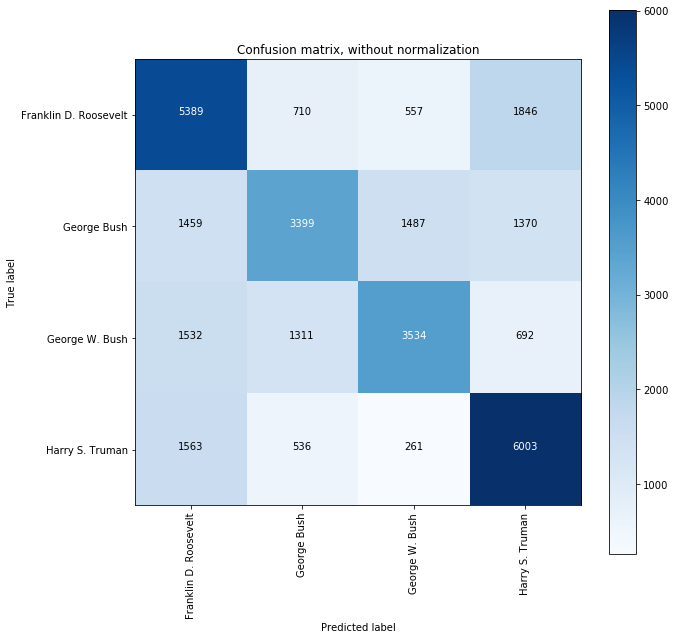

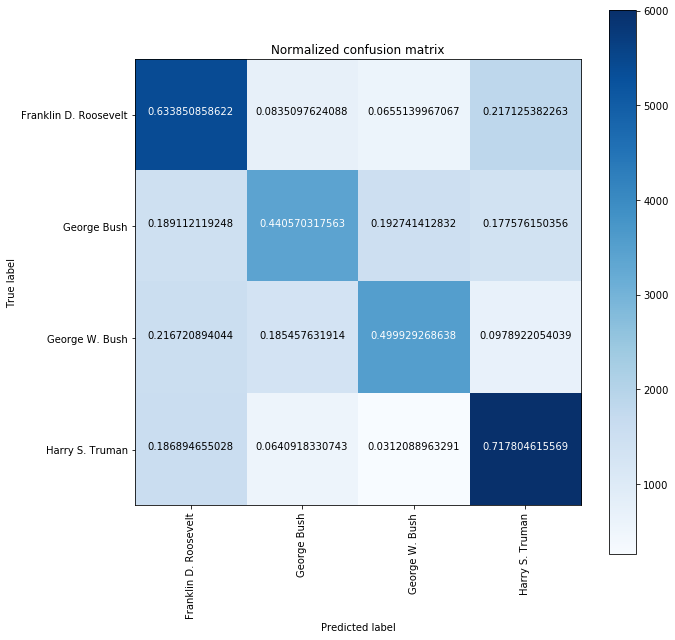

In [15]:
# Plot confusion matrix
#   from scikit-learn examples @
#   http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
%matplotlib inline
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(np.sum(cm,axis=0))

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y_collapsed, pred_y_collapsed)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=(sorted(labels, key=labels.get)),
                      title='Confusion matrix, without normalization')

#Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(np.round(cnf_matrix,2), classes=(sorted(labels, key=labels.get)), normalize=True,
                      title='Normalized confusion matrix')

plt.show()